## <center> **Анализ результатов A/B-тестирования**

Кузьмин Олег 


106_group_dst_92

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data_a = data[data['group']=='A']
data_b = data[data['group']=='B']

In [5]:
print('по группе A:',data_a['date'].min(), 'по', data_a['date'].max(),'\n')
print('по группе B:',data_b['date'].min(), 'по', data_b['date'].max(),'\n')

по группе A: 2021-01-02 00:00:00 по 2021-01-24 00:00:00 

по группе B: 2021-01-02 00:00:00 по 2021-01-24 00:00:00 



## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [84]:
print('количество посещений в группе А:', data_a['user_id'].count()) 
print('cуммарное количество покупок  в группе А:', data_a['purchase'].sum()) 
print('сумма покупок в группе А:', data_a['price'].sum()/1000000)

количество посещений в группе А: 147202
cуммарное количество покупок  в группе А: 17723
сумма покупок в группе А: 1436.26


In [85]:
print('количество посещений в группе B:', data_b['user_id'].count())
print('cуммарное количество покупок  в группе B:', data_b['purchase'].sum())
print('сумма покупок в группе B:', data_b['price'].sum()/1000000)

количество посещений в группе B: 147276
cуммарное количество покупок  в группе B: 17514
сумма покупок в группе B: 1554.1


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [86]:
set_a = set(data_a['user_id'])
set_b = set(data_b['user_id'])
set_inter = set_a.intersection(set_b)
print('Кол-во пользователей, которые в процессе A/B-теста попали в обе тестовые группы:', len(set_inter))

Кол-во пользователей, которые в процессе A/B-теста попали в обе тестовые группы: 1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [9]:
data = data[data['user_id'].apply(lambda x: x not in set_inter)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

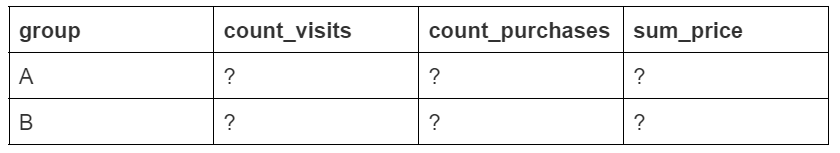
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [10]:
df = data.groupby('group').agg({'user_id': 'count', 'purchase': 'sum', 'price':'sum'}).rename(
    columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price':'sum_price'})
df

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

По количеству и конверсии, можно говорить о сбалансированности между группами, тк разница по кол-ву визитов 0,006%, по кол-ву покупок 0,1%, по сумме покупок 8%

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [11]:
df['conv'] = df['count_purchases']/df['count_visits']*100
df['mean_check'] = round(df['sum_price']/df['count_purchases'])
df

,count_visits,count_purchases,sum_price,conv,mean_check
group,,,,,
A,145307,17487,1417780000,12.034520,81076.0
B,145381,17290,1533010000,11.892888,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

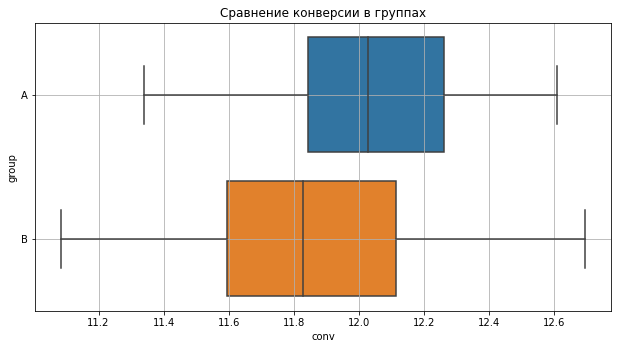

In [89]:
fig = plt.figure(figsize=(8, 4)) 
ax = fig.add_axes([1, 1, 1, 1]) 
sns.boxplot(data=df, x='conv', y='group') 
ax.set_title('Сравнение конверсии в группах')
ax.grid();

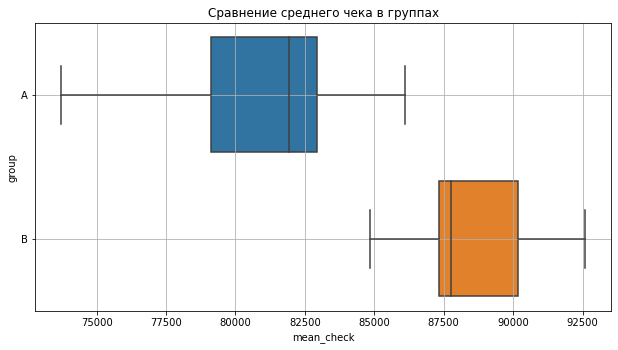

In [91]:
fig = plt.figure(figsize=(8, 4)) 
ax = fig.add_axes([1, 1, 1, 1]) 
sns.boxplot(data=df, x='mean_check', y='group') 
ax.set_title('Сравнение среднего чека в группах')
ax.grid();

предварительно, визуально, можно сказать что по конверсии, вариант А немного предпочтительнее, однако по среднему чеку, вариант В существенно лучше чем А, это видно и по медиане, и по разбросу данных

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [12]:
df_pivot = data.pivot_table(index='group', columns='price', values='user_id', aggfunc='count') 
df_pivot

price,0,10000,60000,100000,150000,200000
group,,,,,,
A,127820,5182,5271,1832,3478,1724
B,128091,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

In [13]:
df_pivot = df_pivot.iloc[:,1:]

Text(0.5, 1.0, 'Количество продаж в группах')

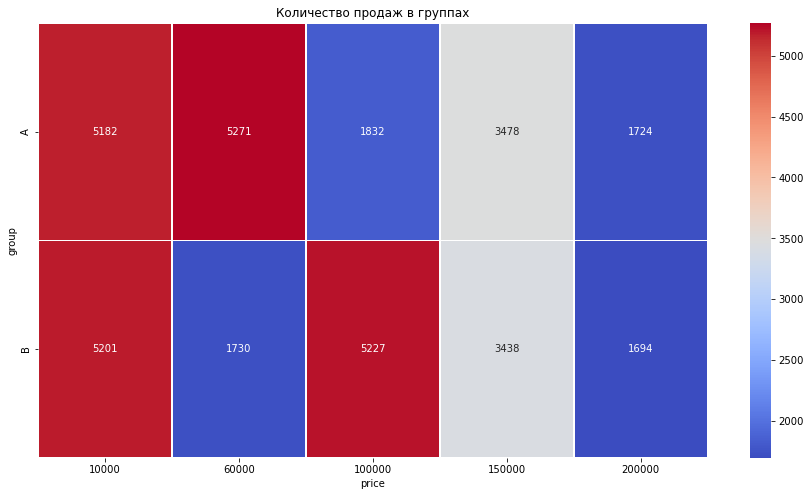

In [14]:
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(df_pivot, annot=True, linewidths=.5, fmt='d', cmap='coolwarm', ax=ax)
ax.set_title('Количество продаж в группах')

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

для наглядности, тепловую карту построил отбросив "зрителей". Разница в активности людей, видна в двух ценовых категориях: 60т-преимущественно категория А, 100т-наоборот, предпочтение отдает категория В. В остальных категориях - паритет.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [15]:
df = data.groupby(['date','group']).agg({'user_id': 'count', 'purchase': 'sum', 'price':'sum'}).rename(
    columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price':'sum_price'}).reset_index()
df['conv'] = df['count_purchases']/df['count_visits']*100
df['mean_check'] = round(df['sum_price']/df['count_purchases'])

display(df[df['date']=='2021-01-03'])

,date,group,count_visits,count_purchases,sum_price,conv,mean_check
2,2021-01-03,A,6596,748,62000000,11.340206,82888.0
3,2021-01-03,B,6619,754,65960000,11.391449,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [16]:
df['cum_visits_count'] = df.groupby(['group'])['count_visits'].cumsum()
df['cum_purchase_count'] = df.groupby(['group'])['count_purchases'].cumsum()
df['cum_price_count'] = df.groupby(['group'])['sum_price'].cumsum()

df['cum_conversion'] = df['cum_purchase_count']/df['cum_visits_count'] * 100
df['cum_mean_check'] = df['cum_price_count']/df['cum_purchase_count']

df.head()
df[df['date']=='2021-01-12']

,date,group,count_visits,count_purchases,sum_price,conv,mean_check,cum_visits_count,cum_purchase_count,cum_price_count,cum_conversion,cum_mean_check
20,2021-01-12,A,6540,795,68460000,12.155963,86113.0,68852,8198,668070000,11.906698,81491.827275
21,2021-01-12,B,6635,807,70560000,12.162773,87435.0,69251,8236,727670000,11.892969,88352.355512


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

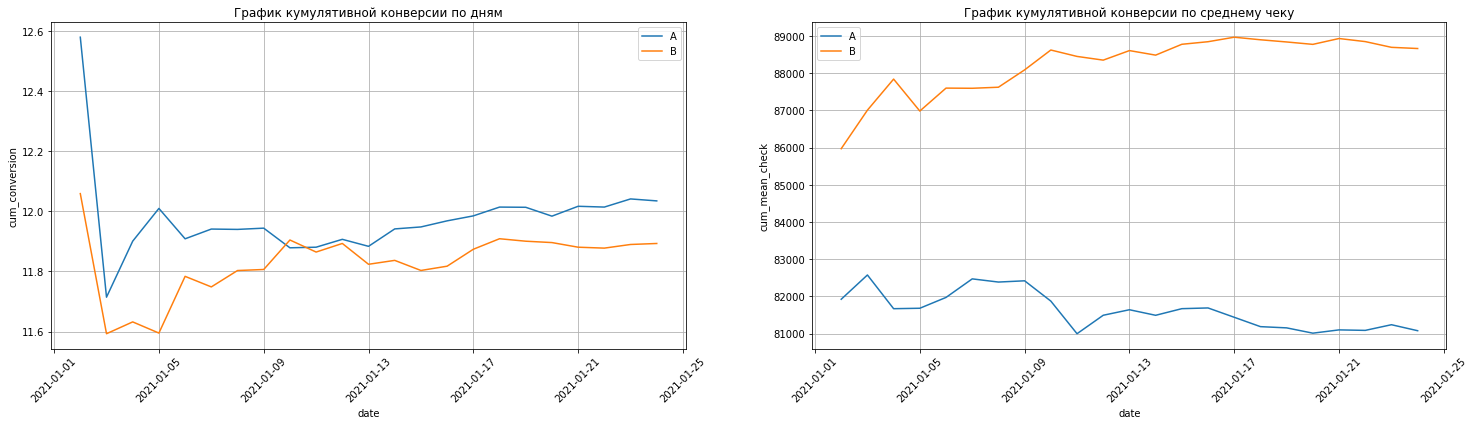

In [17]:
plt.figure(figsize=(25, 6))

plt.subplot(121)
ax = sns.lineplot(x='date', y='cum_conversion', data=df, hue='group')
ax.legend().get_frame().set_facecolor("white")
ax.grid(True)
ax.xaxis.set_tick_params(rotation = 45)
plt.title('График кумулятивной конверсии по дням')

plt.subplot(122)
ax = sns.lineplot(x='date', y='cum_mean_check', data=df, hue='group')
ax.legend().get_frame().set_facecolor("white")
ax.grid(True)
ax.xaxis.set_tick_params(rotation = 45)
plt.title('График кумулятивной конверсии по среднему чеку');

Можно назвать A/B-тест завершенным - значения метрик во времени стабилизировались. 
в кумулятовном рафике конверсии по дням, стабилизация наступила после 13 января, график конверсии по ср чеку наступил чуть раньше.
показатели на левом графике ближе друг к другу и разница в данных практически не отличимы, на правом графике сразу же бросается в глаза преимущество варианта В, причем стабильно и с момента начала наблюдений.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [31]:
converted_piv = data.groupby('group')['purchase'].agg(['sum', 'count', 'mean', 'std'])
converted_piv

,sum,count,mean,std
group,,,,
A,17487,145307,0.120345,0.325366
B,17290,145381,0.118929,0.323706


In [29]:
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

для проверки гипотезы о равенстве конверсий в группах применяем Z-тест, тк сравниваем ровно 2 группы, данных много больше 30, да и равенство долей определяется Z тестом.
значение p-value = 12% это больше, чем уровень значимости alpha=5%, поэтому считаем результаты статистически не значимыми и принимаем нулевую гипотезу о равенстве конверсий.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [49]:
def conversion_conf_interval(n, x_p, gamma=0.95):
    alpha = 1 - gamma 
    z_crit = -norm.ppf(alpha/2) 
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 
    lower_bound = x_p - eps 
    upper_bound = x_p + eps 
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

a_data = data[data['group'] == 'A']
b_data = data[data['group'] == 'B']

conf_interval_a = conversion_conf_interval(a_data['user_id'].count(), a_data['purchase'].mean())
conf_interval_b = conversion_conf_interval(b_data['user_id'].count(), b_data['purchase'].mean())

print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [51]:
def diff_conversion_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma 
    diff = xp[1] - xp[0] 
    z_crit = -norm.ppf(alpha/2)
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps
    upper_bound = diff + eps 
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

n = [a_data['user_id'].count(), b_data['user_id'].count()]
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]

diff_inverval = diff_conversion_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

полученные доверительные интревалы имеют пересечения, это значит, что существует вероятность, что истинное значение конверсии в обеих группах может совпасть, те мы не можем однозначно сказать, есть ли разница в конверсиях. НО тк доверительный интервал для разности конверсий содержит точку ноль, то истинная разница в конверсии может быть как положительной, так и отрицательной, значит варианты А и B равнозначны по метрике конверсии.  
статистическая разница между конверсиями в группах А и B нет

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [94]:
a_data = df[df['group'] == 'A']
b_data = df[df['group'] == 'B']

H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
alpha = 0.05

_, p_a = shapiro(a_data['mean_check'])
_, p_b = shapiro(b_data['mean_check'])

round(p_a,4)
print(p_a)
if p_a > alpha: print('в группе А -', H0)
else: print('в группе А -',Ha)
round(p_b,4)
print(p_b)
if p_b > alpha: print('в группе B -', H0)
else: print('в группе B -',Ha)   

0.2529810070991516
в группе А - Данные распределены нормально
0.09383172541856766
в группе B - Данные распределены нормально


Для проверки гипотезы о нормальности распределения ежедневного среднего чека, применим тест Шапиро-Уилка. нулевая гипотеза - H0 = 'Данные распределены нормально', альтернативная гипотеза - Ha = 'Данные не распределены нормально'. Обе группы распределены нормально, уровень p-value в группе А-25%, в группе В-9%, что выше уровня значимости в 5%

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [76]:
H0 = 'Ежедневные средние чеки в группах А и B равны'
Ha = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05
def t_test(df):
    test_results = ttest_ind(a_data['mean_check'], b_data['mean_check'], alternative='less')    
    p = test_results[1]
    if p>alpha:
        print(f"{p} > {alpha}. \n Мы не можем отвергнуть нулевую гипотезу. \n {H0}")
    else:
        print(f"{p} <= {alpha}. \n Мы отвергаем нулевую гипотезу. {Ha}")
t_test(df)

1.1275579271768679e-12 <= 0.05. 
 Мы отвергаем нулевую гипотезу. Ежедневный средний чек в группе А меньше чем в группе B;


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

применили t-тест для проверки гипотезы о равенстве среднего чека, тк сравниваем ровно две выборки.
мы получили p-value около нуля, это p-value ниже, чем уровень значимости alpha=5%, поэтому считаем результаты статистически значимыми и отклоняем нулевую гипотезу, а значит - Ежедневный средний чек в группе А меньше чем в группе B. Этот же вывод был наглядно продемонстрирован на графике из задания 7.6. Сейчас мы это обосновали статистически

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [95]:
def mean_check_conf_interval(n, x_mean, x_std, gamma=0.95):
    k = n - 1 
    alpha = 1 - gamma 
    t_crit = -t.ppf(alpha/2, k) 
    eps = t_crit * x_std / n**0.5 
    lower_bound = x_mean - eps 
    upper_bound = x_mean + eps 
    return round(lower_bound), round(upper_bound)
 
a_data = df[df['group'] == 'A']
b_data = df[df['group'] == 'B']
 
params_a = {
    'n': a_data['count_visits'].count(), 
    'x_mean': a_data['mean_check'].mean(), 
    'x_std': a_data['mean_check'].std()
}
params_b = {
    'n': b_data['count_visits'].count(),
    'x_mean': b_data['mean_check'].mean(), 
    'x_std': b_data['mean_check'].std() 
}
 
print('Доверительный интервал для среднего чека группы А: {}'.format(mean_check_conf_interval(**params_a))) 
print('Доверительный интервал для среднего чека группы B: {}'.format(mean_check_conf_interval(**params_b)))

Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

In [ ]:
Доверительные интервалы наших групп не имеют пересечений, доверительный интервал группы B всегда больше интервала группы А

## **Сделайте общий вывод по результатам A/B-теста**

Рекомендую одназначно использовать вариант B, для бизнеса характерны финансовые показатели, и рост среднего чека базовый из них.
Проанализировав, доказали с помощью статистики, что конверсия в обеих группах неразличима. Данные стабилизированы и нет большого разброса.